In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import geopy.distance

In [173]:
testDf = pd.read_csv("/shared/3/projects/newsDiffusion/data/processed/newsData/fullDataWithNERCleaned.tsv", sep="\t")

<ipython-input-173-66af72162d2e>:1: DtypeWarning:

Columns (3,4,11,12,14,15,18) have mixed types. Specify dtype option on import or set low_memory=False.



In [179]:
len(testDf["state"].unique()) - 1

46

In [166]:
IN_PATH = "/shared/3/projects/newsDiffusion/data/processed/fullDataWithClustNums.tsv"
df = pd.read_csv(IN_PATH, sep="\t")

df["date"] = pd.to_datetime(df["date"])
df = df.dropna(subset=["date"])

<ipython-input-166-66ffc1fa7484>:2: DtypeWarning:

Columns (2,3,10,11,13,14,17,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.



In [185]:
len(df)

690039

In [167]:
len(df["state"].unique()) - 1

46

In [182]:
len(df["county"].unique())

229

In [168]:
#we can only keep clusters whose first article occured after the 
#first day of local coverage in our data, 4/1
firstLocDate = min(df.loc[df["national"] == False, "date"])
clusteredDates = df[["clustNum", "date"]].groupby(by="clustNum").agg(list).reset_index()
clusteredDates["minDate"] = clusteredDates["date"].apply(lambda x: min(x))
keepClusts = clusteredDates.loc[clusteredDates["minDate"] >= firstLocDate, "clustNum"]

df = df[df["clustNum"].isin(keepClusts)]

In [169]:
len(df["state"].unique()) - 1

46

In [ ]:
#get each date as a date since the first story in our data 
#get the first date in our dataset 
minDate = min(df["date"])

df["dateInt"] = df["date"].apply(lambda x: (x - minDate) / np.timedelta64(1, "D"))

#get largest stories 
clustDf = df[["source", "clustNum", "national", "key", "content", "title", "date", "dateInt", "state", "lat", "lon"]].groupby("clustNum").agg(list).reset_index()
clustDf["clustSize"] = clustDf["key"].apply(len)
clustDf["nationalPercent"] = clustDf["national"].apply(np.mean)
clustDf["duration"] = ((clustDf["date"].apply(max) - clustDf["date"].apply(min)) / np.timedelta64(1, "D")) + 1

def getUnique(inList): 
        return len(set([item for item in inList if item == item]))
    
#get the number of unique states in this story 
clustDf["numStates"] = clustDf["state"].apply(getUnique)

#get variance of our date integer 
clustDf["dateStd"] = clustDf["dateInt"].apply(np.std) 

In [165]:
len(df["state"].unique()) -1 

46

In [34]:
testList = list(clustDf.loc[clustDf["clustNum"] == 8, "dateInt"])[0]

def getQuantile(inList, quant):
    dayOne = min(inList)
    lastDay = max(inList)
    return ((lastDay - dayOne) / 4) + minDay

In [32]:
#get the quartile for this stories trajectory in terms of which days are reported on 
clustDf["storyQuartile"] = clustDf["dateInt"].apply(getQuantile, args=[.25])

In [35]:
#explode and find only articles that are in the first quarter of their respective story clusters 
#do this eventually but maybe not first pass? 

In [36]:
#find the furthest that a story reaches for each story 

In [58]:
#clustDf[["clustNum", "key", "lat", "lon"]]
def getFurthestDist(inSeries): 
    lats = inSeries["lat"]
    lons = inSeries["lon"]
    
    #get the distance between the current lat/lon pair 
    #when i == j we are comparing with the same pair we are already considering 
    candLats = [item for item in inSeries["lat"] if item == item and item != np.nan]
    candLons = [item for item in inSeries["lon"] if item == item and item != np.nan]

    if len(candLats) == 0: 
        return np.nan
    
    maxDists = []
    #for each lat lon pair, get the shortest distance to any other lat lon pair 
    for i, key in enumerate(inSeries["key"]): 
        lat = lats[i]
        lon = lons[i]
        
        #this checks if either are nans
        if lat == lat and lon == lon: 
            distList = [geopy.distance.geodesic((lat, lon), (candLats[j], candLons[j])).miles for j in range(0, len(candLats))]
            maxDists.append(max(distList))
        else: 
            maxDists.append(np.nan)
    return maxDists

clustDf["furthestDist"] = clustDf[clustDf["nationalPercent"] < 1].apply(getFurthestDist, axis=1)

In [73]:
expandedDists = clustDf.dropna(subset=("furthestDist"))

In [74]:
keepCols = ["source", "national", "date", "dateInt", "state", "furthestDist"]
expandedDists = expandedDists[keepCols + ["clustNum"]].explode(keepCols)

In [75]:
expandedDists = expandedDists.dropna(subset="furthestDist")

In [79]:
#for each outlet, we want to get the furthest outlet it has in each cluster 
maxClustDists = expandedDists.sort_values(["clustNum", "furthestDist"], ascending=False).drop_duplicates(["source", "clustNum"])

In [104]:
averageDists = maxClustDists[["state", "furthestDist"]].groupby("state").agg(np.mean).sort_values("furthestDist")

In [89]:
import geopandas as gpd

/opt/anaconda/lib/python3.8/site-packages/geopandas/_compat.py:123: UserWarning:

The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.



In [123]:
states = gpd.read_file("/home/blitt/reference/geospatial/shapeFiles/2022_census_states/tl_2022_us_state.shp")

In [136]:
averageDists["furthestDist"] = averageDists["furthestDist"].astype(float)

In [137]:
distsMerged = pd.merge(states.rename(columns={"NAME":"state"}),averageDists, on="state", how="left")

(array([17., 15.,  9.,  2.,  1.,  1.,  0.,  0.,  0.,  1.]),
 array([ 153.32590468,  408.18907023,  663.05223578,  917.91540133,
        1172.77856688, 1427.64173243, 1682.50489798, 1937.36806353,
        2192.23122908, 2447.09439463, 2701.95756018]),
 <BarContainer object of 10 artists>)

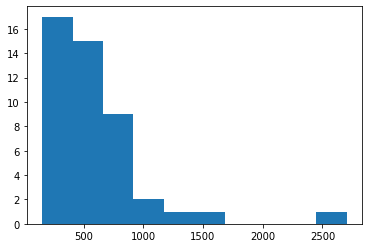

In [143]:
plt.hist(distsMerged["furthestDist"])

In [146]:
distsMerged["logFurthestDist"] = np.log(distsMerged["furthestDist"])

Text(0.5, 212.7055695423244, '*Log scale')

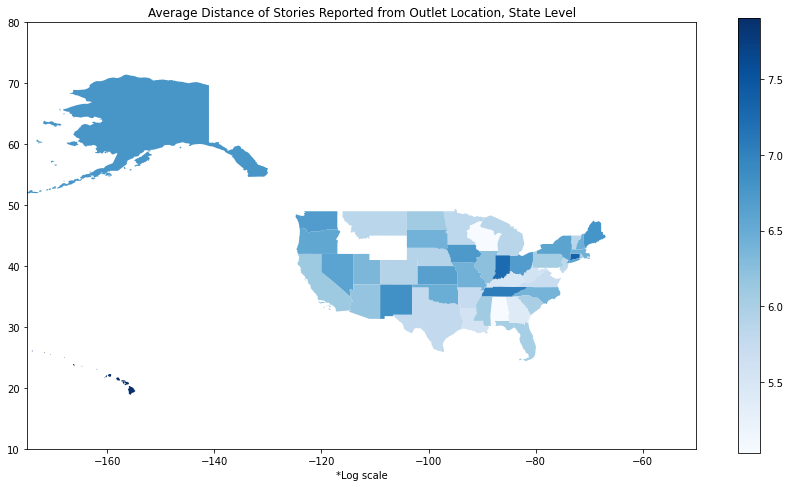

In [176]:
fig, ax = plt.subplots(1, figsize=(15, 8))
distsMerged[["geometry", "logFurthestDist"]].plot(column="logFurthestDist", cmap="Blues", linewidth=1, ax=ax, legend=True)
plt.xlim(-175, -50)
plt.ylim(10, 80)
plt.title("Average Distance of Stories Reported from Outlet Location, State Level")
plt.xlabel("*Log scale")